## 4. **Product Recommendation System**
   - *Objective*: Develop a recommendation system based on user reviews, ratings, and preferences.
   - *Business Value*: Increases sales by suggesting relevant books to users based on their preferences and past interactions.
   - *Approach*: Implement collaborative filtering or content-based filtering techniques.

### Content-Based Filtering with Sentiment Labels

1. Create User Profiles: Aggregate sentiment labels from user reviews to create profiles.
 
2. Compute Similarities: Use these profiles to find similar books.
 
3. Recommend Books: Recommend books similar to those that a user liked based on sentiment.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_reviews_with_sentiment = pd.read_csv("/kaggle/input/merged-dataframe/merged data.csv")
df_reviews_with_sentiment.head()

,Unnamed: 0,Title,authors,publisher,publishedYear,categories,description,hybrid_score
0,0,church christ biblical ecclesiology today,['Everett Ferguson'],Wm. B. Eerdmans Publishing,1996,['Religion'],church christ biblical ecclesiology today resp...,3.993130
1,1,voice farm adventure community live,['Rupert Fike'],Book Publishing Company,2012,['Biography & Autobiography'],twentyfive year ago height counterculture move...,4.203766
2,2,battleship bismarck,['Stefan Draminski'],Bloomsbury Publishing,2018,['History'],bismarck perhaps famous notorious warship ever...,3.413042
3,3,tess highlander,['May Mcgoldrick'],Harper Collins,2002,['Juvenile Fiction'],windswept isle scotland seventeenyearold tess ...,3.942543
4,4,beginner yoruba hippocrene beginners series,['Kayode J. Fakinlede'],Hippocrene Books,2005,['Foreign Language Study'],beginner yoruba available two accompany audio ...,3.838243


In [3]:
df_reviews_with_sentiment.shape

(40634, 8)

In [4]:
df_reviews_with_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40634 entries, 0 to 40633
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     40634 non-null  int64  
 1   Title          40583 non-null  object 
 2   authors        40634 non-null  object 
 3   publisher      40634 non-null  object 
 4   publishedYear  40634 non-null  int64  
 5   categories     40634 non-null  object 
 6   description    40617 non-null  object 
 7   hybrid_score   40634 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 2.5+ MB


In [5]:
df_reviews_with_sentiment.isnull().sum()

Unnamed: 0        0
Title            51
authors           0
publisher         0
publishedYear     0
categories        0
description      17
hybrid_score      0
dtype: int64

In [6]:
# Remove rows where the null value count is insignificant
df_reviews_with_sentiment.dropna(subset=['Title', 'description'], inplace = True)

missing_values = df_reviews_with_sentiment.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Unnamed: 0       0
Title            0
authors          0
publisher        0
publishedYear    0
categories       0
description      0
hybrid_score     0
dtype: int64


In [7]:
df_reviews_with_sentiment.shape

(40566, 8)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import vstack

In [9]:
# Define chunk size
chunk_size = 1000  

# Initialize variables to store results
cosine_sim_list = []

# Convert lemmatized reviews to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')

# Handle missing values in 'Lemmatized review/text' (replace NaN with empty strings)
df_reviews_with_sentiment['description'] = df_reviews_with_sentiment['description'].fillna('')

# Adjust the length to exclude the last chunk if it's smaller than chunk_size
adjusted_len = len(df_reviews_with_sentiment) // chunk_size * chunk_size

# Fit the vectorizer on the entire dataset to ensure consistent vocabulary
print("Fitting the TF-IDF vectorizer on the entire dataset...")
vectorizer.fit(df_reviews_with_sentiment['description'])

# Process the dataset in chunks
num_chunks = adjusted_len // chunk_size
print(f"Processing dataset in {num_chunks} chunks of size {chunk_size}, ignoring the last {len(df_reviews_with_sentiment) - adjusted_len} rows...")

# Process data in full-size chunks
for i in range(num_chunks):
    # Define the range for this chunk
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    # Extract the chunk of text data
    chunk = df_reviews_with_sentiment['description'].iloc[start_idx:end_idx]
    
    # Convert to TF-IDF features for this chunk using the pre-fitted vectorizer
    print(f"Chunk {i+1}/{num_chunks}: Converting text to TF-IDF...")
    tfidf_chunk = vectorizer.transform(chunk)
    
    # Store the TF-IDF matrix of this chunk
    cosine_sim_list.append(tfidf_chunk)
    
    # Provide feedback after processing each chunk
    print(f"Chunk {i+1}/{num_chunks} processed and stored.\n")

# Combine all TF-IDF matrices into one large matrix
print("Combining all chunks into the final TF-IDF matrix...")
tfidf_matrix = vstack(cosine_sim_list)

print("TF-IDF matrix computed successfully.\n")

# Compute the cosine similarity matrix
print("Computing cosine similarity matrix...")
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print("Cosine similarity matrix computed successfully.\n")

# Create the recommendation function
def recommend_books_with_sentiment(title, cosine_sim=cosine_sim, df=df_reviews_with_sentiment):
    idx = df.index[df['Title'] == title].tolist()[0]
    
    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Multiply similarity scores by the sentiment score of each book to weight the recommendations
    sim_scores = [(i, score * df['hybrid_score'].iloc[i]) for i, score in sim_scores]
    
    # Sort the books based on similarity and sentiment scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the most similar books (excluding the queried book itself)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    
    # Return the titles of the top 10 most similar books
    return df['Title'].iloc[book_indices]

# Example usage 1
print("Recommending books...")
recommended_books = recommend_books_with_sentiment('battleship bismarck')
print(recommended_books)

Fitting the TF-IDF vectorizer on the entire dataset...
Processing dataset in 40 chunks of size 1000, ignoring the last 566 rows...
Chunk 1/40: Converting text to TF-IDF...
Chunk 1/40 processed and stored.

Chunk 2/40: Converting text to TF-IDF...
Chunk 2/40 processed and stored.

Chunk 3/40: Converting text to TF-IDF...
Chunk 3/40 processed and stored.

Chunk 4/40: Converting text to TF-IDF...
Chunk 4/40 processed and stored.

Chunk 5/40: Converting text to TF-IDF...
Chunk 5/40 processed and stored.

Chunk 6/40: Converting text to TF-IDF...
Chunk 6/40 processed and stored.

Chunk 7/40: Converting text to TF-IDF...
Chunk 7/40 processed and stored.

Chunk 8/40: Converting text to TF-IDF...
Chunk 8/40 processed and stored.

Chunk 9/40: Converting text to TF-IDF...
Chunk 9/40 processed and stored.

Chunk 10/40: Converting text to TF-IDF...
Chunk 10/40 processed and stored.

Chunk 11/40: Converting text to TF-IDF...
Chunk 11/40 processed and stored.

Chunk 12/40: Converting text to TF-IDF..

In [23]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


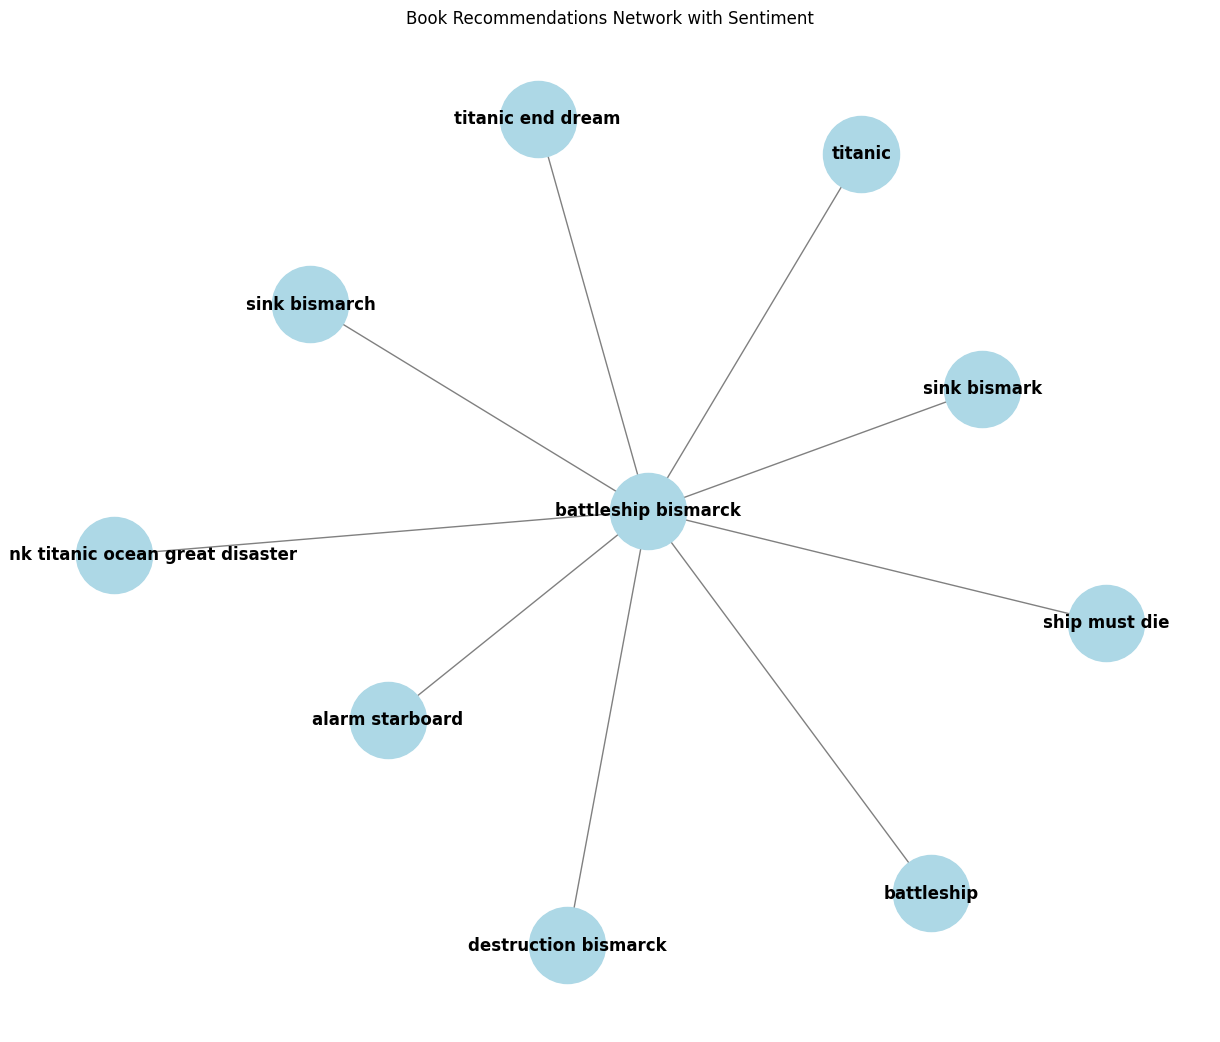

In [11]:
# Network Graph for recommendations with sentiment incorporated
import networkx as nx
import matplotlib.pyplot as plt

def plot_recommendations_with_sentiment(title, cosine_sim=cosine_sim, df=df_reviews_with_sentiment):
    idx = df.index[df['Title'] == title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Adjust similarity by sentiment score
    sim_scores = [(i, score * df['hybrid_score'].iloc[i]) for i, score in sim_scores]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    similar_books = df.iloc[book_indices]

    # Build the network graph
    G = nx.Graph()
    for i, row in similar_books.iterrows():
        G.add_node(row['Title'])
    
    for i, (j, score) in enumerate(sim_scores):
        if i > 0:
            G.add_edge(df.iloc[idx]['Title'], df.iloc[j]['Title'], weight=score)
    
    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, edge_color='gray', font_size=12, font_weight='bold')
    plt.title('Book Recommendations Network with Sentiment')
    plt.show()

plot_recommendations_with_sentiment('battleship bismarck')

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_recommendations_with_sentiment(title, cosine_sim=cosine_sim, df=df_reviews_with_sentiment):
    idx = df.index[df['Title'] == title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Adjust similarity by sentiment score
    sim_scores = [(i, score * df['hybrid_score'].iloc[i]) for i, score in sim_scores]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    similar_books = df.iloc[book_indices]

    # Build the network graph
    G = nx.Graph()
    for i, row in similar_books.iterrows():
        G.add_node(row['Title'])
    
    for i, (j, score) in enumerate(sim_scores):
        if i > 0:
            G.add_edge(df.iloc[idx]['Title'], df.iloc[j]['Title'], weight=score)
    
    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, edge_color='gray', font_size=12, font_weight='bold')
    plt.title('Book Recommendations Network with Sentiment')
    plt.show()

# Create a text input widget for book title
title_input = widgets.Text(
    description='Book Title:',
    value='battleship bismarck',  # Default value
    style={'description_width': 'initial'}
)

# Define a function to update the plot based on the input title
def update_graph(title):
    plot_recommendations_with_sentiment(title)

# Link the text input widget to the update function
widgets.interactive(update_graph, title=title_input)

interactive(children=(Text(value='battleship bismarck', description='Book Title:', style=DescriptionStyle(desc…